In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
import numpy as np

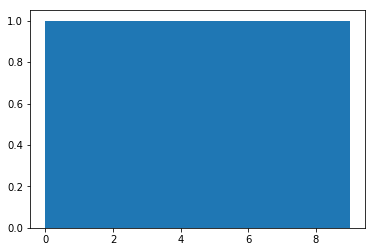

In [2]:
plt.hist(np.arange(10))
plt.show()

In [3]:
from __future__ import print_function
import time, os, glob
import ROOT
from array import array
from hist_utils_zee import *

Welcome to JupyROOT 6.20/02


In [4]:
def get_cp_err(num, den, num_err=None, den_err=None):

        # Clopper-Pearson errors
        # tail = (1 - cl) / 2
        # 2sigma (95% CL): tail = (1 - 0.95) / 2 = 0.025
        # 1sigma (68% CL): tail = (1 - 0.68) / 2 = 0.16
        tail = 0.16
        
        if num == 0. or den == 0: return 1.
        
        if num_err is None:
            num_err = np.sqrt(num)
        if den_err is None:
            den_err = np.sqrt(den)

        n_num = pow(num/num_err, 2.)
        n_den = pow(den/den_err, 2.)

        # nom
        n_rat = n_num / n_den

        # lower limit
        q_low = ROOT.Math.fdistribution_quantile_c(1-tail, n_num*2, (n_den+1)*2)
        r_low = q_low * n_num / (n_den + 1)

        # upper limit
        q_high = ROOT.Math.fdistribution_quantile_c(tail, (n_num+1)*2, n_den*2)
        r_high = q_high * (n_num + 1) / n_den

        # lower, upper errors
        err_lo, err_hi = n_rat - r_low, r_high - n_rat

        #return err_lo, err_hi
        #err_ = np.sqrt(np.mean(np.array([err_lo, err_hi])**2))
        err_ = err_lo if num/den > 1. else err_hi
        return err_

In [5]:
samples = ['Run2017', 'DYToEE']
#samples = ['Run2017']
ma, wgt = {}, {}

for s in samples:
    in_files = glob.glob('Templates/%s*_ma1.txt'%s)
    print(in_files)
    
    ma[s], wgt[s] = [], []
    for in_file in in_files:
        f = open(in_file, "r")
        for l in f:
            ma_, wgt_ = l.replace('\n','').split(':')
            ma[s].append(float(ma_))
            wgt[s].append(float(wgt_))

    ma[s] = np.array(ma[s])
    wgt[s] = np.array(wgt[s])
    wgt[s] = wgt[s][ma[s] > -0.2]
    ma[s] = ma[s][ma[s] > -0.2]
    assert len(ma[s] == wgt[s])
    print(len(ma[s]), len(wgt[s]))
    print(ma[s][:5])
    print(wgt[s][:5])

['Templates/Run2017B_ma1.txt', 'Templates/Run2017E_ma1.txt', 'Templates/Run2017C_ma1.txt', 'Templates/Run2017D_ma1.txt']
1960031 1960031
[0.069651 0.039235 0.082894 0.139563 0.51743 ]
[1. 1. 1. 1. 1.]
['Templates/DYToEE_ma1.txt']
2084409 2084409
[-0.104737 -0.005871  0.348417  0.206033  0.112075]
[0.969015 0.931203 0.760811 0.830483 0.930548]


[-0.2   -0.175 -0.15  -0.125 -0.1   -0.075 -0.05  -0.025  0.     0.025
  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225  0.25   0.275
  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475  0.5    0.525
  0.55   0.575  0.6    0.625  0.65   0.675  0.7    0.725  0.75   0.775
  0.8    0.825  0.85   0.875  0.9    0.925  0.95   0.975  1.     1.025
  1.05   1.075  1.1    1.125  1.15   1.175  1.2    1.6  ]
[-0.1875 -0.1625 -0.1375 -0.1125 -0.0875 -0.0625 -0.0375 -0.0125  0.0125
  0.0375  0.0625  0.0875  0.1125  0.1375  0.1625  0.1875  0.2125  0.2375
  0.2625  0.2875  0.3125  0.3375  0.3625  0.3875  0.4125  0.4375  0.4625
  0.4875  0.5125  0.5375  0.5625  0.5875  0.6125  0.6375  0.6625  0.6875
  0.7125  0.7375  0.7625  0.7875  0.8125  0.8375  0.8625  0.8875  0.9125
  0.9375  0.9625  0.9875  1.0125  1.0375  1.0625  1.0875  1.1125  1.1375
  1.1625  1.1875  1.2125]
mc, mean: 0.160984, stdev:0.246927
data, mean: 0.161888, stdev:0.256152
data corr, mean: 0.163193, stdev:0.248723


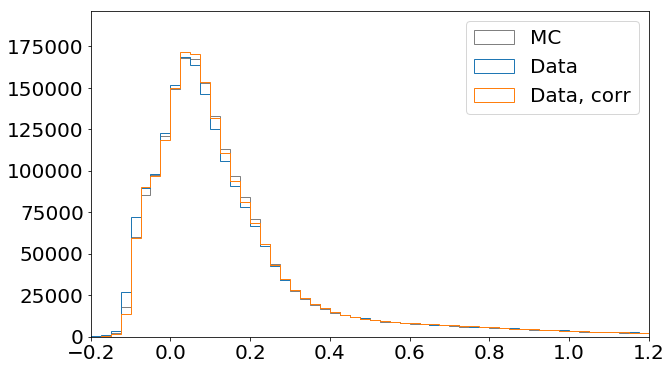

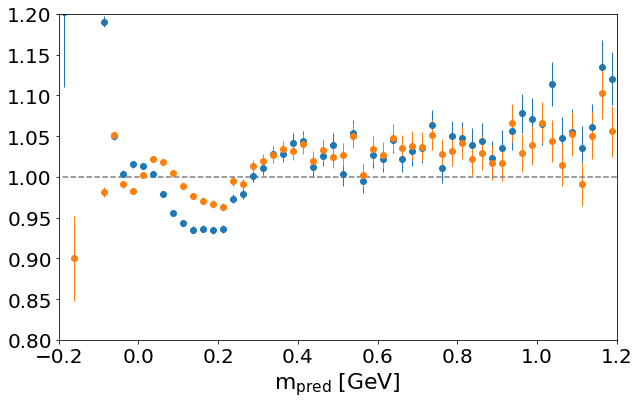

In [6]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({'font.size': 20})

#bins_ = 120
dM = 25
#bins_ = np.concatenate([[-0.2], np.arange(0,1200+dM,dM)/1000., [1.6]])
bins_ = np.concatenate([np.arange(-200,0,dM)/1000., np.arange(0,1200+dM,dM)/1000., [1.6]])
bin_ctrs = bins_[:-1].copy()
#bin_ctrs[0] = bin_ctrs[0]+0.1
bin_ctrs[0] = bin_ctrs[0]+(dM/2000.)
bin_ctrs[1:] = bin_ctrs[1:]+(dM/2000.)
#xlims = [-0., 0.2]
xlims = [-0.2, 1.2]
print(bins_)
print(bin_ctrs)

def smear(ma, scale, offset, sigma, sigma_frac=None):
    '''if sigma_frac is None:
        gauss = np.random.normal(mu, sigma, size=len(ma))
        ma_smeared = [m*g for m, g in zip(ma, gauss)]
    else:'''
    if sigma_frac is None:
        #ma_smeared = [np.random.normal((scale*m)+offset, sigma) for m in ma]
        ma_smeared = scale*np.array(ma) + offset if sigma == 0. else scale*np.array([np.random.normal(m, sigma) for m in ma])+offset
    else:
        ma_smeared = [np.random.normal((scale*m)+offset, sigma_frac*m) for m in ma]
    return ma_smeared
    
def plot_datavmc(ma, wgt, scale, offset, sigma=0., make_plot=True):

    mcwgts = wgt['DYToEE']*len(ma['Run2017'][ma['Run2017']>-0.2])/sum(wgt['DYToEE'][wgt['DYToEE']>-0.2])
    #ma_shift = scale*ma['Run2017'] + offset
    ma_shift = smear(ma['Run2017'], scale, offset, sigma, sigma_frac=None)
    
    if make_plot:
        fig = plt.figure()
    hmc, edges, _ = plt.hist(ma['DYToEE'], bins=bins_, histtype='step', label='MC', weights=mcwgts, color='grey')
    mean = np.mean(ma['DYToEE'])
    stdev = np.std(np.array(ma['DYToEE'])-mean)
    print('mc, mean: %f, stdev:%f'%(mean, stdev))
    hdata, edges, _ = plt.hist(ma['Run2017'], bins=bins_, histtype='step', label='Data', color='C0')
    mean = np.mean(ma['Run2017'])
    stdev = np.std(np.array(ma['Run2017'])-mean)
    print('data, mean: %f, stdev:%f'%(mean, stdev))
    hdata2, edges, _ = plt.hist(ma_shift, bins=bins_, histtype='step', label='Data, corr', color='C1')
    mean = np.mean(ma_shift)
    stdev = np.std(np.array(ma_shift)-mean)
    print('data corr, mean: %f, stdev:%f'%(mean, stdev))
    if not make_plot:
        plt.close()
    
    if make_plot:
        plt.xlim(xlims)
        plt.ylim(0., np.sort(hdata)[-2]*1.2)
        #plt.xlabel(r'$\mathrm{m_{pred}}$', size=22)
        plt.legend(loc='upper right')
        plt.show()

        #'''
        fig = plt.figure()
        plt.plot(np.concatenate([[-0.4],bin_ctrs]), np.ones(len(bin_ctrs)+1), color='grey', linestyle='--')
        plt.errorbar(bin_ctrs, hdata/hmc, [get_cp_err(d,mc) for d,mc in zip(hdata, hmc)], marker='o', elinewidth=1., drawstyle='steps-mid', linewidth=0.)
        plt.errorbar(bin_ctrs, hdata2/hmc, [get_cp_err(d,mc) for d,mc in zip(hdata2, hmc)], marker='o', elinewidth=1., drawstyle='steps-mid', linewidth=0.)
        plt.ylim(1.-.2, 1.+.2)
        plt.xlim(xlims)
        plt.xlabel(r'$\mathrm{m_{pred}\;[GeV]}$', size=22)
        plt.show()
        #'''

    return edges, hmc, hdata, hdata2

scale=0.971#0.971
offset=6.e-3
sigma=1.e-2
edges, hmc, hdata, hdata2 = plot_datavmc(ma, wgt, scale, offset)#, sigma)

1893313.60785
376477.78125
1939469.0
414656.0


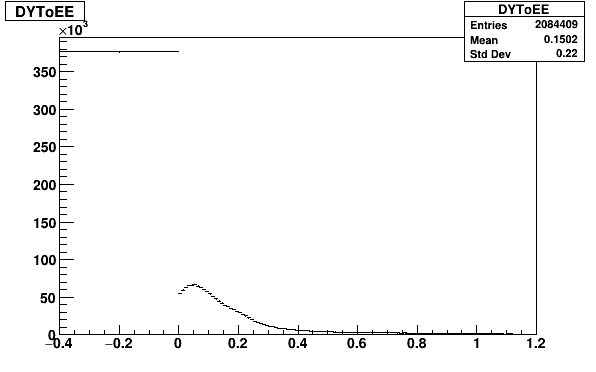

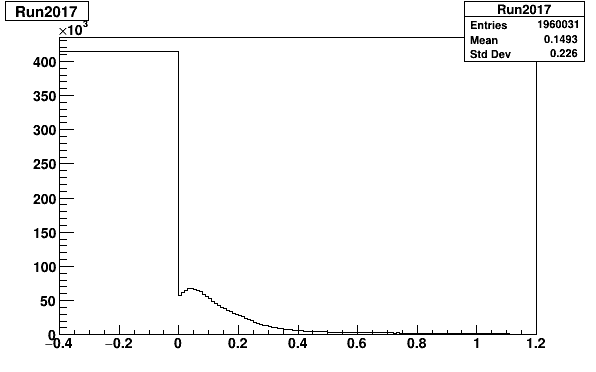

In [7]:
h, c = {}, {}

#dM = 25
dM = 10
ma_bins = list(range(0,1200+dM,dM))
ma_bins = [-400]+ma_bins
#ma_bins = [-400, -200]+ma_bins
ma_bins = [float(m)/1.e3 for m in ma_bins]
#print(len(ma_bins))
n_ma_bins = len(ma_bins)-1
ma_bins = array('d', ma_bins)
#print(ma_bins)

k = 'DYToEE'
kmc = k
#h[k] = ROOT.TH1F(k, k, 48, 0., 1.2)
#h[k] = ROOT.TH1F(k, k, 56, -0.2, 1.2)
h[k] = ROOT.TH1F(k, k, n_ma_bins, ma_bins)
c[k] = ROOT.TCanvas(k, k, 600, 400)
for i,m in enumerate(ma[k]):
    #if i+1 >= 30000: break
    #m = (1./0.97)*(m - 0.006)
    h[k].Fill(m, wgt['DYToEE'][i])
h[k].Draw()
c[k].Draw()
print(h[k].Integral())
print(h[k].GetBinContent(1))

k = 'Run2017'
kdata = k
#h[k] = ROOT.TH1F(k, k, 48, 0., 1.2)
#h[k] = ROOT.TH1F(k, k, 56, -0.2, 1.2)
h[k] = ROOT.TH1F(k, k, n_ma_bins, ma_bins)
c[k] = ROOT.TCanvas(k, k, 600, 400)
for i,m in enumerate(ma[k]):
    #if i+1 >= 30000: break
    h[k].Fill(m)
h[k].Draw()
c[k].Draw()
print(h[k].Integral())
print(h[k].GetBinContent(1))

In [8]:
#'''
#print(ma_bins)
scale = 0.971
offset = 0.006
mcwgts = wgt['DYToEE']*len(ma['Run2017'][ma['Run2017']>-0.2])/sum(wgt['DYToEE'][wgt['DYToEE']>-0.2])
#datawgts = np.ones(len(ma['Run2017']))*sum(wgt['DYToEE'][wgt['DYToEE']>-0.2])/len(ma['Run2017'][ma['Run2017']>-0.2])
#print(len(mcwgts))
#print(len(datawgts))
#ma_shift = smear(ma['Run2017'], 0.97, 0.006, sigma, sigma_frac=None)
ma_shift = scale*np.array(ma['Run2017']) + offset
#ma_shift = np.array(ma['Run2017'])
#print(len(ma_shift))
#hdata_shift, edges, _ = plt.hist(ma_shift, bins=ma_bins, histtype='step', label='MC', weights=datawgts, color='grey')
hdata_shift, _ = np.histogram(ma_shift, bins=ma_bins)#, weights=datawgts)
hdata_shift = np.float64(hdata_shift)
hdata_shift *= (h['DYToEE'].Integral()/hdata_shift.sum())
#plt.show()

im = h['Run2017'].GetXaxis().FindBin(-0.2)
print(im)
print(hdata_shift.sum())
print(hdata_shift[im-1])
print(hdata_shift)
print(len(hdata_shift))
#'''

1
1893313.6078491213
371931.52475065103
[371931.52475065  55199.71323471  59582.54609481  63545.22749524
  66795.30862415  68301.42000512  67605.39183294  66314.71774336
  64153.52102387  60933.65960551  57111.35363477  53949.98197878
  50218.33513971  47261.67765201  43706.47492942  41192.38997697
  38282.52429917  36319.21794235  34147.29809976  32106.98022249
  30196.3146518   28181.34233823  26291.14818437  24175.7684454
  22245.60628726  20417.80121326  18214.68683074  16524.33269831
  15104.98113151  13701.22683468  12734.19609687  11606.31851254
  10738.72037075  10068.03776226   9311.57016897   8685.72971163
   8194.41570774   7541.28002797   7256.62985111   6819.9062921
   6341.26507005   6127.77743741   5793.41096254   5427.84994774
   5306.97110551   5050.59098047   4994.05087685   4549.52868285
   4578.77356403   4331.16690334   4097.20785387   4063.08882582
   4022.14599217   3858.37465754   3833.02909384   3682.90537043
   3497.6877896    3522.05852392   3389.48172922   3

In [9]:
k = 'linear_x_ma'

scale_nom, offset_nom = 0.97, 0.006
#datawgts = np.ones(len(ma['Run2017']))#*h['DYToEE'].Integral()/len(ma['Run2017'][(ma['Run2017']>=-0.4) & (ma['Run2017']<1.2)])

def linear_x_ma(x, par):
    #kfit = 'DYToEE'
    kfit = 'Run2017'
    ma_ = par[1]*np.array(ma[kfit]) + par[0]
    hdata_shift, _ = np.histogram(ma_, bins=ma_bins)#, weights=datawgts)
    hdata_shift = np.float64(hdata_shift)
    hdata_shift *= (h['DYToEE'].Integral()/hdata_shift.sum())
    im = h[kfit].GetXaxis().FindBin(x[0])
    if im > len(hdata_shift): im = len(hdata_shift)
    if im <= 0: im = 0
    return hdata_shift[im-1]
    #return hdata_shift[0]

amin = array('d', (1,))
edm = array('d', (1,))
errdef = array('d', (1,))
nvpar = array('i', (1,))
nparx = array('i', (1,))

steps = np.arange(1,2)/1.e3
steps = np.concatenate([-np.flip(steps), [0.], steps])
#steps = [0.]

for s in steps:
    for o in steps:
        
        scale = scale_nom + s
        offset = offset_nom + o
        print('=======================')
        print('scale:',scale)
        print('offset:',offset)
        
        #'''
        h[k] = ROOT.TF1(k, linear_x_ma, -0.4, 1.2, 2)
        h[k].SetParName(0, 'offset')
        h[k].SetParName(1, 'scale')
        h[k].FixParameter(0, offset)
        h[k].FixParameter(1, scale)
        #h[k].SetParameter(0, offset)
        #h[k].SetParameter(1, scale)

        #'''
        h['DYToEE'].Fit(h[k], "L")
        chi2 = h[k].GetChisquare()
        ndof = h[k].GetNDF()        
        fitter = ROOT.TVirtualFitter.Fitter(h[k])
        fitter.GetStats(amin, edm, errdef, nvpar, nparx)
        print('2*LL: %f | chi2 / ndf: %f / %.f = %f'%(amin[0], chi2, ndof, chi2/ndof))
        #'''

scale: 0.969
offset: 0.005
2*LL: 580.767706 | chi2 / ndf: 1259.831414 / 121 = 10.411830
scale: 0.969
offset: 0.006
2*LL: 522.058257 | chi2 / ndf: 1143.519203 / 121 = 9.450572
scale: 0.969
offset: 0.007
2*LL: 602.074274 | chi2 / ndf: 1323.483768 / 121 = 10.937882
scale: 0.97
offset: 0.005
2*LL: 574.852827 | chi2 / ndf: 1248.599851 / 121 = 10.319007
scale: 0.97
offset: 0.006
2*LL: 519.988897 | chi2 / ndf: 1139.942116 / 121 = 9.421009
scale: 0.97
offset: 0.007
2*LL: 603.595763 | chi2 / ndf: 1327.663804 / 121 = 10.972428
scale: 0.971
offset: 0.005
2*LL: 572.242841 | chi2 / ndf: 1243.159912 / 121 = 10.274049
scale: 0.971
offset: 0.006
2*LL: 524.050009 | chi2 / ndf: 1150.323217 / 121 = 9.506803
scale: 0.971
offset: 0.007
2*LL: 604.322630 | chi2 / ndf: 1330.508130 / 121 = 10.995935
 FCN=580.768 FROM FIX         STATUS=RESET           0 CALLS           0 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP  

In [ ]:
'''
=======================
scale: 0.969
offset: 0.005
2*LL: 580.767706 | chi2 / ndf: 1259.831414 / 121 = 10.411830
=======================
scale: 0.969
offset: 0.006
2*LL: 522.058257 | chi2 / ndf: 1143.519203 / 121 = 9.450572
=======================
scale: 0.969
offset: 0.007
2*LL: 602.074274 | chi2 / ndf: 1323.483768 / 121 = 10.937882
=======================
scale: 0.97
offset: 0.005
2*LL: 574.852827 | chi2 / ndf: 1248.599851 / 121 = 10.319007
=======================
scale: 0.97
offset: 0.006
2*LL: 519.988897 | chi2 / ndf: 1139.942116 / 121 = 9.421009
=======================
scale: 0.97
offset: 0.007
2*LL: 603.595763 | chi2 / ndf: 1327.663804 / 121 = 10.972428
=======================
scale: 0.971
offset: 0.005
2*LL: 572.242841 | chi2 / ndf: 1243.159912 / 121 = 10.274049
=======================
scale: 0.971
offset: 0.006
2*LL: 524.050009 | chi2 / ndf: 1150.323217 / 121 = 9.506803
=======================
scale: 0.971
offset: 0.007
2*LL: 604.322630 | chi2 / ndf: 1330.508130 / 121 = 10.995935

=======================
scale: 0.971
offset: 0.006
2*LL: 524.050009 | chi2 / ndf: 1150.323217 / 121.000000 = 9.506803
'''

In [15]:
print(h['DYToEE'].Integral())
print(h['linear_x_ma'].Eval(-0.2))
print(h['linear_x_ma'].Eval(1.199))

1893313.60785
371931.524751
896.843022975


1893313.61926
371931.53125


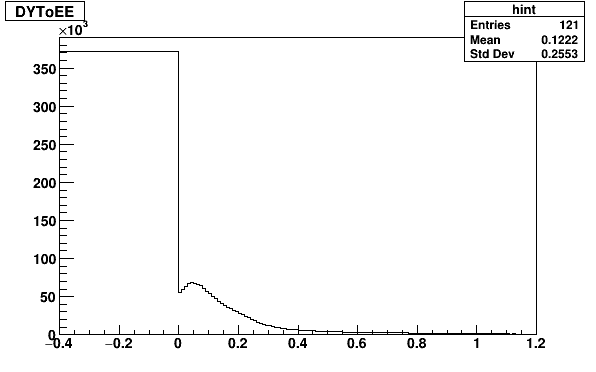

In [16]:
k = 'int'
c[k] = ROOT.TCanvas(k, k, 600, 400)
h[k] = h['DYToEE'].Clone()
h[k].Reset()
h[k].SetName('hint')
(ROOT.TVirtualFitter.GetFitter()).GetConfidenceIntervals(h[k], 0.683)
print(h[k].Integral())
print(h[k].GetBinContent(1))
h[k].Draw()
c[k].Draw()

In [18]:
print(h[k].GetNbinsX())
print(h[k].GetBinContent(121))
count = 0
for i in range(0, h[k].GetNbinsX()+1):
    count += h[k].GetBinContent(i)
print(count)

121
896.843017578
1893313.61926


In [ ]:
'''
scale: 0.97
offset: 0.006
2*LL=440.290287, chi2=19.596172

scale: 0.97
offset: 0.005
2*LL=500.948615, chi2=22.122392

scale: 0.97
offset: 0.007
2*LL=510.672717, chi2=22.785457
'''

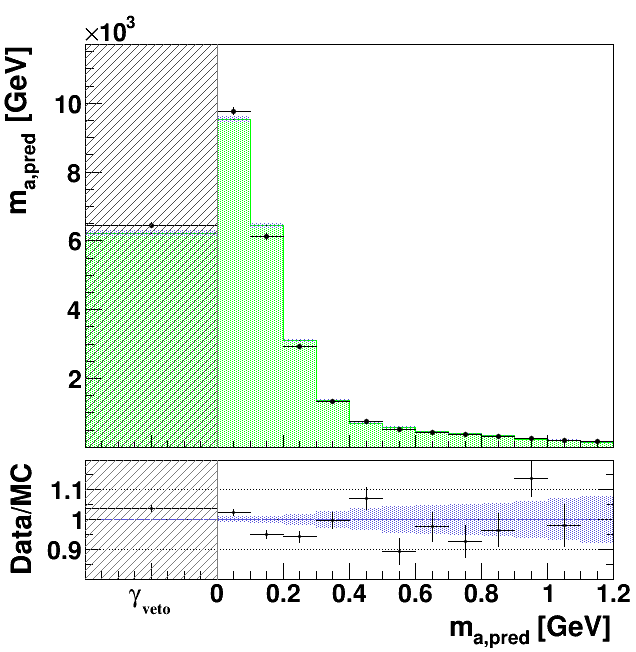

In [63]:
#def draw_hist_1dmastacked(ymax_=None, mcnorm=1.):

hc = {}

err_style = 'E2'
fill_style = 3002
wd, ht = int(640*1), int(680*1)
#ROOT.TGaxis.fgMaxDigits = 3
#ROOT.gStyle.SetErrorX(0)

k = kdata
c[k] = ROOT.TCanvas("c%s"%k,"c%s"%k,wd,ht)

pUp = ROOT.TPad("upperPad", "upperPad",.005, .300, .995, .995) # (,,Double_t xlow, Double_t ylow, Double_t xup, Double_t yup,...)
pDn = ROOT.TPad("lowerPad", "lowerPad",.005, .005, .995, .300)
pUp.Draw()
pDn.Draw()
pUp.SetMargin(13.e-02,3.e-02,2.e-02,9.e-02) # (Float_t left, Float_t right, Float_t bottom, Float_t top)
pDn.SetMargin(13.e-02,3.e-02,36.e-02,2.e-02) # (Float_t left, Float_t right, Float_t bottom, Float_t top)

pUp.cd()

# dummy hist for drawing axes
hdummy = h[k].Clone()
hdummy.Reset()
hdummy = set_hist(hdummy, "m_{a,pred} [GeV]", "N_{a}", "")
hdummy.GetYaxis().SetTitle('m_{a,pred} [GeV]')
hdummy.GetXaxis().SetTitle('')
hdummy.GetXaxis().SetLabelSize(0.)
hdummy.GetYaxis().SetTitleOffset(0.9)
hdummy.GetYaxis().SetTitleSize(0.07)
hdummy.GetYaxis().SetLabelSize(0.06)
hdummy.GetYaxis().SetMaxDigits(3)
hdummy.SetLineColor(0)
hdummy.Draw("hist")

# Plot MC
k = kmc
h[k].Scale(h[kdata].Integral()/h[kmc].Integral())
# Plot fill
hc[k] = h[k].Clone()
hc[k].SetLineColor(3)
hc[k].SetFillColor(3)
hc[k].SetFillStyle(fill_style)
hc[k].Draw("hist same")
# Plot uncertainty
h[k].SetLineColor(9)
h[k].SetFillColor(9)
h[k].SetFillStyle(fill_style)
h[k].Draw("%s same"%err_style)

# Plot data
k = kdata
hc[k] = h[k].Clone()
hc[k].SetFillStyle(0)
hc[k].SetMarkerStyle(20)
#hc[k].SetMarkerSize(0.85)
hc[k].SetMarkerSize(0.5)
hc[k].Draw("E same")

#if ymax_ is None and hc[k].GetBinContent(2) > 0.:
ymax = 1.2*max(np.max([hc[kdata].GetBinContent(ib) for ib in range(2, hc[kdata].GetNbinsX()+2)]),
               np.max([hc[kmc].GetBinContent(ib) for ib in range(2, hc[kmc].GetNbinsX()+2)]))
hdummy.GetYaxis().SetRangeUser(0.1, ymax)
ROOT.gPad.RedrawAxis()

l, l2, hatch = {}, {}, {}
legend = {}

'''l[k] = ROOT.TLine(0.135, 0., 0.135, ymax) # x0,y0, x1,y1
l[k].SetLineColor(14)
l[k].SetLineStyle(7)
l[k].Draw("same")

l2[k] = ROOT.TLine(0.55, 0., 0.55, ymax) # x0,y0, x1,y1
l2[k].SetLineColor(14)
l2[k].SetLineStyle(7)
l2[k].Draw("same")'''

hatch[k] = ROOT.TGraph(2, array('d',[0.,0.]), array('d',[0.,ymax]));
hatch[k].SetLineColor(14)
hatch[k].SetLineWidth(5001)
#hatch[k].SetLineWidth(5)
hatch[k].SetFillStyle(3004)
#hatch[k].SetFillColor(14)
hatch[k].SetFillColor(12)
#ROOT.gStyle.SetHatchesLineWidth(2)
hatch[k].Draw("same")

#legend[k] = ROOT.TLegend(0.5,0.68,0.8,0.86) #(x1, y1, x2, y2)
#legend[k].AddEntry(hc[kdata].GetName(),"Obs","l")
#legend[k].AddEntry(hc[kmc].GetName(),"Exp","l")
#legend[k].SetBorderSize(0)
#legend[k].Draw("same")

##### Ratio plots on lower pad #####
pDn.cd()
pDn.SetTicky()
pDn.SetGridy()

fUnity = ROOT.TF1("fUnity","[0]",-0.4,1.2)
fUnity.SetParameter( 0,1. )

fUnity.GetXaxis().SetTitle("m_{a,pred} [GeV]")
fUnity.GetXaxis().SetTickLength(0.1)
fUnity.GetXaxis().SetTitleOffset(1.05)
fUnity.GetXaxis().SetTitleSize(0.16)
fUnity.GetXaxis().SetLabelSize(0.14)
fUnity.GetXaxis().ChangeLabel(1,-1, 0,-1,-1,-1,"")
fUnity.GetXaxis().ChangeLabel(2,-1,-1,-1,-1,-1,"#font[22]{#gamma_{veto}}")

dY = 0.199
#dY = 0.399
#fUnity.GetYaxis().SetTitle("SB/SR")
fUnity.GetYaxis().SetTitle("Data/MC")
#fUnity.GetYaxis().SetRangeUser(1.-dY,1.+dY)
fUnity.SetMaximum(1.+dY)
fUnity.SetMinimum(1.-dY)
fUnity.GetYaxis().SetNdivisions(305)
fUnity.GetYaxis().SetTickLength(0.04)
fUnity.GetYaxis().SetLabelFont(62)
fUnity.GetYaxis().SetTitleFont(62)
fUnity.GetYaxis().SetTitleOffset(.4)
fUnity.GetYaxis().SetTitleSize(0.16)
fUnity.GetYaxis().SetLabelSize(0.14)

fUnity.SetLineColor(9)
fUnity.SetLineWidth(1)
fUnity.SetLineStyle(7)
fUnity.SetTitle("")
fUnity.Draw()

# Stat error bands
k = kdata
kr = kdata+'err'
h[kr] = ROOT.TGraphAsymmErrors()
h[kr].SetName(kr)
for i in range(h[k].GetNbinsX()-1):
    ib = i+2
    h[kr].SetPoint(i, h[k].GetBinCenter(ib), 1.)
    h[kr].SetPointError(
        i,
        h[k].GetBinWidth(ib)/2.,
        h[k].GetBinWidth(ib)/2.,
        (h[k].GetBinError(ib)/h[k].GetBinContent(ib)),
        (h[k].GetBinError(ib)/h[k].GetBinContent(ib)),
        )
h[kr].SetFillColor(9)
h[kr].SetFillStyle(3002)
h[kr].Draw("E2 same")

# Data/MC
kr = 'dataomc'
h[kr] = h[kdata].Clone()
h[kr].Reset()
for ib in range(1, h[k].GetNbinsX()+1):
    obs = h[kdata].GetBinContent(ib)
    obs_err = h[kdata].GetBinError(ib)
    bkg = h[kmc].GetBinContent(ib)
    if bkg == 0.: continue
    bkg_err = h[kmc].GetBinError(ib)
    h[kr].SetBinContent(ib, obs/bkg)
    h[kr].SetBinError(ib, obs_err/obs)
#h[kr].SetLineColor(9)
#h[kr].SetStats(0)
#h[kr].Divide(h[kmc])
h[kr].SetMarkerStyle(20)
#h[kr].SetMarkerSize(0.85)
h[kr].SetMarkerSize(0.45)
h[kr].SetMarkerColor(1)
h[kr].SetLineColor(1) #9
h[kr].Draw("ep same")

k = kr
'''l[k] = ROOT.TLine(0.135, 1.-dY, 0.135, 1.+dY) # x0,y0, x1,y1
l[k].SetLineColor(14)
l[k].SetLineStyle(7)
l[k].Draw("same")

l2[k] = ROOT.TLine(0.55, 1.-dY, 0.55, 1.+dY) # x0,y0, x1,y1
l2[k].SetLineColor(14)
l2[k].SetLineStyle(7)
l2[k].Draw("same")'''

hatch[k] = ROOT.TGraph(2, array('d',[0.,0.]), array('d',[1.-dY,1.+dY]));
hatch[k].SetLineColor(14)
hatch[k].SetLineWidth(5001)
hatch[k].SetFillStyle(3004)
hatch[k].SetFillColor(14)
hatch[k].Draw("same")

k = kdata
c[k].Draw()
c[k].Update()
#c[k].Print('Plots/%s_sb2srvsr_blind_%s.eps'%(samples, blind))
#c[k].Print('Plots/%s_sb2srvsr_blind_%.eps'%(samples, blind))
#samples_str = '_'.join(samples)
#c[k].Print('Plots/%s_dataomc_blind_%s_%s.eps'%(samples_str, blind, k))

#draw_hist_1dmastacked()